# Customer Review Sentiment Analysis

This notebook provides an interactive exploration of customer review sentiment analysis using various deep learning models.

## Overview
- **Objective**: Classify customer reviews as positive or negative
- **Models**: Neural Bag of Words (NBoW), LSTM, CNN, Transformer (BERT)
- **Framework**: PyTorch with modern NLP techniques

## Table of Contents
1. [Setup and Data Loading](#setup)
2. [Data Exploration](#exploration)
3. [Text Preprocessing](#preprocessing)
4. [Model Training](#training)
5. [Model Evaluation](#evaluation)
6. [Inference and Prediction](#inference)
7. [Model Comparison](#comparison)

## 1. Setup and Data Loading {#setup}

First, let's import the necessary libraries and load our data.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Import our custom modules
import sys
import os
sys.path.append('..')

try:
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader
    print(f"PyTorch version: {torch.__version__}")
    print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
except ImportError:
    print("PyTorch not installed. Please run: pip install -r requirements.txt")

# Import our modules
from utils.data_loader import ReviewDataset, CustomDataLoader
from utils.preprocessing import TextPreprocessor, VocabularyBuilder
from utils.training import Trainer
from utils.visualization import *
from models.nbow import NBoW
from models.lstm import LSTMModel
from models.cnn import CNNModel
from models.transformer import TransformerModel

PyTorch version: 2.7.1+cpu
Device: CPU


In [2]:
# Load sample data
data_path = '../data/sample_reviews.csv'

try:
    df = pd.read_csv(data_path)
    print(f"Data loaded successfully: {len(df)} reviews")
    print(f"Columns: {df.columns.tolist()}")
    display(df.head())
except FileNotFoundError:
    print(f"Data file not found at {data_path}")
    print("Creating sample data...")
    
    # Create sample data
    sample_reviews = [
        ("This product is amazing! I love it so much.", "positive"),
        ("Terrible quality, waste of money.", "negative"),
        ("Great value for money, highly recommend.", "positive"),
        ("Poor customer service, disappointed.", "negative"),
        ("Excellent product, exceeded my expectations.", "positive"),
        ("Not worth the price, very disappointed.", "negative"),
        ("Perfect for my needs, very satisfied.", "positive"),
        ("Broke after one day, terrible quality.", "negative"),
        ("Outstanding quality and fast delivery.", "positive"),
        ("Completely useless, don't buy this.", "negative")
    ]
    
    df = pd.DataFrame(sample_reviews, columns=['review_text', 'sentiment'])
    print("Sample data created:")
    display(df)

Data loaded successfully: 50 reviews
Columns: ['review_text', 'sentiment']


,review_text,sentiment
0,This product is amazing! I love it so much.,positive
1,"Terrible quality, waste of money.",negative
2,"Great value for money, highly recommend.",positive
3,"Poor customer service, disappointed.",negative
4,"Excellent product, exceeded my expectations.",positive


## 2. Data Exploration {#exploration}

Let's explore our dataset to understand its characteristics.

In [ ]:
# Basic statistics
print("Dataset Overview:")
print(f"Total reviews: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"Data types: {df.dtypes.to_dict()}")
print(f"Missing values: {df.isnull().sum().to_dict()}")

# Sentiment distribution
print("\nSentiment Distribution:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)
print(f"Positive ratio: {sentiment_counts.get('positive', 0) / len(df):.2%}")
print(f"Negative ratio: {sentiment_counts.get('negative', 0) / len(df):.2%}")

In [ ]:
# Plot sentiment distribution
plt.figure(figsize=(10, 6))

# Sentiment distribution
plt.subplot(1, 2, 1)
sentiment_counts = df['sentiment'].value_counts()
colors = ['#FF6B6B', '#4ECDC4']
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Sentiment Distribution')

# Text length distribution
plt.subplot(1, 2, 2)
text_lengths = df['review_text'].str.len()
plt.hist(text_lengths, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(text_lengths.mean(), color='red', linestyle='--', label=f'Mean: {text_lengths.mean():.1f}')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.title('Review Length Distribution')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Word count analysis
df['word_count'] = df['review_text'].str.split().str.len()

print("Word Count Statistics:")
print(df['word_count'].describe())

# Word count by sentiment
plt.figure(figsize=(10, 6))
for sentiment in df['sentiment'].unique():
    subset = df[df['sentiment'] == sentiment]
    plt.hist(subset['word_count'], alpha=0.7, label=sentiment, bins=10)

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution by Sentiment')
plt.legend()
plt.show()

## 3. Text Preprocessing {#preprocessing}

Now let's preprocess the text data for our models.

In [3]:
# Initialize preprocessor
preprocessor = TextPreprocessor()

# Example preprocessing
sample_text = "This product is AMAZING!!! I love it so much. Best purchase ever! 😍"

print("Text Preprocessing Example:")
print(f"Original: {sample_text}")
print(f"Cleaned: {preprocessor.clean_text(sample_text)}")
print(f"Tokenized: {preprocessor.tokenize(sample_text)}")
print(f"Preprocessed: {preprocessor.preprocess_text(sample_text)}")

Text Preprocessing Example:
Original: This product is AMAZING!!! I love it so much. Best purchase ever! 😍
Cleaned: this product is amazing!!! i love it so much. best purchase ever! 😍
Tokenized: ['This', 'product', 'is', 'AMAZING!!!', 'I', 'love', 'it', 'so', 'much.', 'Best', 'purchase', 'ever!', '😍']
Preprocessed: ['product', 'amazing!!!', 'love', 'so', 'much.', 'best', 'purchase', 'ever!']


In [4]:
# Preprocess all reviews
print("Preprocessing all reviews...")
texts = df['review_text'].astype(str).tolist()
processed_texts = [preprocessor.preprocess_text(text) for text in texts]

# Show examples
print("\nProcessing Examples:")
for i in range(min(3, len(texts))):
    print(f"Original: {texts[i]}")
    print(f"Processed: {processed_texts[i]}")
    print("-" * 50)

Preprocessing all reviews...

Processing Examples:
Original: This product is amazing! I love it so much.
Processed: ['product', 'amazing!', 'love', 'so', 'much.']
--------------------------------------------------
Original: Terrible quality, waste of money.
Processed: ['terrible', 'quality,', 'waste', 'money.']
--------------------------------------------------
Original: Great value for money, highly recommend.
Processed: ['great', 'value', 'money,', 'highly', 'recommend.']
--------------------------------------------------


In [5]:
# Build vocabulary
vocab_builder = VocabularyBuilder(min_freq=1, max_vocab_size=1000)
vocab = vocab_builder.build_from_texts(processed_texts)

print(f"Vocabulary size: {len(vocab)}")
print(f"Sample vocabulary: {list(vocab.items())[:10]}")

# Convert text to indices
max_length = 50
text_indices = [vocab_builder.text_to_indices(tokens, max_length) for tokens in processed_texts]

print(f"\nText to indices example:")
print(f"Tokens: {processed_texts[0]}")
print(f"Indices: {text_indices[0]}")

Vocabulary size: 104
Sample vocabulary: [('<pad>', 0), ('<unk>', 1), ('product,', 2), ('great', 3), ('not', 4), ('poor', 5), ('quality.', 6), ('very', 7), ('terrible', 8), ('quality,', 9)]

Text to indices example:
Tokens: ['product', 'amazing!', 'love', 'so', 'much.']
Indices: [10, 51, 17, 52, 53, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## 4. Model Training {#training}

Let's train different models and compare their performance.

In [6]:
# Prepare data for training
from sklearn.model_selection import train_test_split

# Convert labels to integers
labels = df['sentiment'].tolist()
label_to_idx = {'negative': 0, 'positive': 1}
y = [label_to_idx[label] for label in labels]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    text_indices, y, test_size=0.2, random_state=42, stratify=y
)

# Create simple dataset class for tokenized data
class TokenizedDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return {
            'text': torch.tensor(self.texts[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets
train_dataset = TokenizedDataset(X_train, y_train)
test_dataset = TokenizedDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Vocabulary size: {len(vocab)}")

Training samples: 40
Test samples: 10
Vocabulary size: 104


In [7]:
# Train Neural Bag of Words model
print("Training Neural Bag of Words (NBoW) model...")

# Create model
nbow_model = NBoW(
    vocab_size=len(vocab),
    embedding_dim=50,
    hidden_dim=64,
    output_dim=2,
    dropout_rate=0.5
)

# Initialize trainer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = Trainer(nbow_model, device=device)

# Train model
history = trainer.fit(
    train_loader=train_loader,
    val_loader=test_loader,  # Using test as validation for demo
    epochs=10,
    lr=1e-3,
    early_stopping_patience=5
)

print("NBoW training completed!")

Training Neural Bag of Words (NBoW) model...
Starting training on cpu...
Model parameters: 12,754
Batch 0/5, Loss: 0.7309
Epoch 1/10 (0.03s)
Train - Loss: 0.7124, Acc: 0.4500
Val - Loss: 0.6932, Acc: 0.5000
Val Metrics - Precision: 0.2500, Recall: 0.5000, F1: 0.3333
Learning Rate: 0.001000
--------------------------------------------------
Batch 0/5, Loss: 0.6813
Epoch 2/10 (0.01s)
Train - Loss: 0.7011, Acc: 0.4750
Val - Loss: 0.6932, Acc: 0.5000
Val Metrics - Precision: 0.2500, Recall: 0.5000, F1: 0.3333
Learning Rate: 0.001000
--------------------------------------------------
Batch 0/5, Loss: 0.7224
Epoch 3/10 (0.01s)
Train - Loss: 0.6793, Acc: 0.5750
Val - Loss: 0.6933, Acc: 0.5000
Val Metrics - Precision: 0.2500, Recall: 0.5000, F1: 0.3333
Learning Rate: 0.001000
--------------------------------------------------
Batch 0/5, Loss: 0.6938
Epoch 4/10 (0.01s)
Train - Loss: 0.7040, Acc: 0.4500
Val - Loss: 0.6934, Acc: 0.5000
Val Metrics - Precision: 0.2500, Recall: 0.5000, F1: 0.3333
L

In [ ]:
# Plot training history
plot_training_history(history)

In [ ]:
# Evaluate model
print("Evaluating NBoW model...")
results = trainer.evaluate(test_loader)

print(f"Test Accuracy: {results['accuracy']:.4f}")
print(f"Test Precision: {results['precision']:.4f}")
print(f"Test Recall: {results['recall']:.4f}")
print(f"Test F1-Score: {results['f1']:.4f}")

# Plot confusion matrix
class_names = ['Negative', 'Positive']
plot_confusion_matrix(results['confusion_matrix'], class_names)

## 5. Model Evaluation {#evaluation}

Let's evaluate our model's performance in detail.

In [ ]:
# Classification report
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(results['labels'], results['predictions'], 
                          target_names=class_names))

# Plot classification report
plot_classification_report(results['labels'], results['predictions'], class_names)

In [ ]:
# Analyze predictions
test_df = pd.DataFrame({
    'review': [texts[i] for i in range(len(X_test))],
    'true_label': [class_names[label] for label in results['labels']],
    'predicted_label': [class_names[pred] for pred in results['predictions']],
    'confidence': [max(prob) for prob in results['probabilities']]
})

# Show correct predictions
correct_predictions = test_df[test_df['true_label'] == test_df['predicted_label']]
print(f"Correct predictions: {len(correct_predictions)}")
print("\nSample correct predictions:")
display(correct_predictions.head())

# Show incorrect predictions
incorrect_predictions = test_df[test_df['true_label'] != test_df['predicted_label']]
print(f"\nIncorrect predictions: {len(incorrect_predictions)}")
if len(incorrect_predictions) > 0:
    print("Sample incorrect predictions:")
    display(incorrect_predictions.head())

## 6. Inference and Prediction {#inference}

Let's test our model on new reviews.

In [ ]:
def predict_sentiment(text, model, vocab_builder, preprocessor, device):
    """Predict sentiment for a single text."""
    model.eval()
    
    # Preprocess text
    tokens = preprocessor.preprocess_text(text)
    indices = vocab_builder.text_to_indices(tokens, max_length)
    
    # Convert to tensor
    input_tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    return {
        'sentiment': class_names[predicted_class],
        'confidence': confidence,
        'probabilities': {
            'negative': probabilities[0][0].item(),
            'positive': probabilities[0][1].item()
        }
    }

# Test on new reviews
test_reviews = [
    "This product exceeded my expectations!",
    "Terrible quality, complete waste of money.",
    "Pretty good, but could be better.",
    "Absolutely love this! Highly recommend.",
    "Not bad, but not great either."
]

print("Testing on new reviews:")
for review in test_reviews:
    result = predict_sentiment(review, nbow_model, vocab_builder, preprocessor, device)
    print(f"Review: {review}")
    print(f"Sentiment: {result['sentiment']} (confidence: {result['confidence']:.3f})")
    print(f"Probabilities: {result['probabilities']}")
    print("-" * 50)

In [ ]:
# Interactive prediction
def interactive_prediction():
    """Interactive sentiment prediction."""
    print("Interactive Sentiment Analysis")
    print("Enter a review to analyze (or 'quit' to exit):")
    
    while True:
        user_input = input("\nYour review: ")
        
        if user_input.lower() == 'quit':
            break
        
        if user_input.strip():
            result = predict_sentiment(user_input, nbow_model, vocab_builder, preprocessor, device)
            print(f"Sentiment: {result['sentiment']}")
            print(f"Confidence: {result['confidence']:.3f}")
            print(f"Probabilities: {result['probabilities']}")
        else:
            print("Please enter a valid review.")

# Uncomment to run interactive prediction
# interactive_prediction()

## 7. Model Comparison {#comparison}

Let's compare different model architectures.

In [ ]:
# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name, train_loader, test_loader, epochs=10):
    """Train and evaluate a model."""
    print(f"Training {model_name}...")
    
    trainer = Trainer(model, device=device)
    
    history = trainer.fit(
        train_loader=train_loader,
        val_loader=test_loader,
        epochs=epochs,
        lr=1e-3,
        early_stopping_patience=5
    )
    
    results = trainer.evaluate(test_loader)
    
    return {
        'model': model,
        'trainer': trainer,
        'history': history,
        'results': results
    }

# Compare models
model_results = {}

# NBoW (already trained)
model_results['NBoW'] = {
    'accuracy': results['accuracy'],
    'precision': results['precision'],
    'recall': results['recall'],
    'f1': results['f1']
}

# LSTM Model
try:
    lstm_model = LSTMModel(
        vocab_size=len(vocab),
        embedding_dim=50,
        hidden_dim=64,
        output_dim=2,
        num_layers=2,
        dropout_rate=0.5
    )
    
    lstm_result = train_and_evaluate_model(lstm_model, 'LSTM', train_loader, test_loader, epochs=5)
    model_results['LSTM'] = {
        'accuracy': lstm_result['results']['accuracy'],
        'precision': lstm_result['results']['precision'],
        'recall': lstm_result['results']['recall'],
        'f1': lstm_result['results']['f1']
    }
except Exception as e:
    print(f"Error training LSTM: {e}")

# CNN Model
try:
    cnn_model = CNNModel(
        vocab_size=len(vocab),
        embedding_dim=50,
        output_dim=2,
        filter_sizes=[3, 4, 5],
        num_filters=50,
        dropout_rate=0.5
    )
    
    cnn_result = train_and_evaluate_model(cnn_model, 'CNN', train_loader, test_loader, epochs=5)
    model_results['CNN'] = {
        'accuracy': cnn_result['results']['accuracy'],
        'precision': cnn_result['results']['precision'],
        'recall': cnn_result['results']['recall'],
        'f1': cnn_result['results']['f1']
    }
except Exception as e:
    print(f"Error training CNN: {e}")

print("\nModel Comparison Results:")
comparison_df = pd.DataFrame(model_results).T
display(comparison_df)

In [ ]:
# Plot model comparison
if len(model_results) > 1:
    plot_model_comparison(model_results)
else:
    print("Need at least 2 models for comparison")

## Summary

This notebook demonstrated:

1. **Data Loading and Exploration**: Understanding the dataset structure and characteristics
2. **Text Preprocessing**: Cleaning and preparing text data for neural networks
3. **Model Training**: Training different deep learning models for sentiment analysis
4. **Evaluation**: Comprehensive evaluation of model performance
5. **Inference**: Making predictions on new data
6. **Model Comparison**: Comparing different architectures

### Key Takeaways:
- Text preprocessing is crucial for good model performance
- Different model architectures have different strengths
- Proper evaluation metrics help understand model behavior
- Interactive prediction enables practical use cases

### Next Steps:
1. Try the transformer model with pre-trained embeddings
2. Experiment with different hyperparameters
3. Use larger datasets for better generalization
4. Implement more sophisticated preprocessing techniques
5. Deploy the model for real-world applications

## Model Improvement Strategy

The current model has low accuracy due to several factors:
1. **Very small dataset** (only 50 samples)
2. **Poor text preprocessing** 
3. **Simple model architecture**
4. **Limited regularization**

Let's implement improvements to boost performance.

In [8]:
# Create a larger synthetic dataset for better training
def create_expanded_dataset():
    """Create a larger, more diverse dataset."""
    
    # Positive sentiment templates
    positive_templates = [
        "This product is {adj}! I {verb} it {adv}.",
        "{adj} quality, {adv} recommend it.",
        "Amazing {noun}, {verb} my expectations.",
        "Great {noun} for the price, very {adj}.",
        "Outstanding {noun}, {adv} satisfied.",
        "Perfect for my needs, {adv} {adj}.",
        "Excellent {noun}, {verb} it {adv}.",
        "Best {noun} I've {verb}, highly {adj}.",
        "Superior quality, {adv} {adj}.",
        "Fantastic {noun}, {verb} using it."
    ]
    
    # Negative sentiment templates
    negative_templates = [
        "This product is {adj}! I {verb} it.",
        "Terrible {noun}, {adj} quality.",
        "Poor {noun}, {adv} disappointed.",
        "Waste of money, {adv} {adj}.",
        "Horrible {noun}, {verb} after one day.",
        "Cheap {noun}, not worth the price.",
        "Disappointing {noun}, {adv} {adj}.",
        "Worst {noun} ever, {adv} recommend.",
        "Defective {noun}, {verb} immediately.",
        "Useless {noun}, {adj} quality."
    ]
    
    # Word pools for templates
    positive_words = {
        'adj': ['amazing', 'excellent', 'fantastic', 'wonderful', 'great', 'perfect', 'outstanding', 'superb', 'brilliant', 'awesome'],
        'verb': ['love', 'adore', 'enjoy', 'appreciate', 'treasure', 'value', 'cherish', 'exceeded', 'surpassed', 'impressed'],
        'adv': ['highly', 'strongly', 'definitely', 'absolutely', 'completely', 'totally', 'really', 'truly', 'very', 'extremely'],
        'noun': ['product', 'item', 'purchase', 'device', 'tool', 'equipment', 'gadget', 'appliance', 'accessory', 'solution']
    }
    
    negative_words = {
        'adj': ['terrible', 'awful', 'horrible', 'disappointing', 'poor', 'bad', 'worst', 'useless', 'defective', 'broken'],
        'verb': ['hate', 'dislike', 'regret', 'broke', 'failed', 'stopped', 'malfunctioned', 'disappointed', 'wasted', 'ruined'],
        'adv': ['completely', 'totally', 'extremely', 'very', 'really', 'absolutely', 'utterly', 'highly', 'never', 'definitely'],
        'noun': ['product', 'item', 'purchase', 'device', 'tool', 'equipment', 'gadget', 'appliance', 'accessory', 'waste']
    }
    
    expanded_reviews = []
    
    # Generate positive reviews
    for _ in range(200):
        template = np.random.choice(positive_templates)
        words = {key: np.random.choice(positive_words[key]) for key in positive_words}
        review = template.format(**words)
        expanded_reviews.append((review, 'positive'))
    
    # Generate negative reviews
    for _ in range(200):
        template = np.random.choice(negative_templates)
        words = {key: np.random.choice(negative_words[key]) for key in negative_words}
        review = template.format(**words)
        expanded_reviews.append((review, 'negative'))
    
    # Add original reviews
    for _, row in df.iterrows():
        expanded_reviews.append((row['review_text'], row['sentiment']))
    
    # Create DataFrame
    expanded_df = pd.DataFrame(expanded_reviews, columns=['review_text', 'sentiment'])
    expanded_df = expanded_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle
    
    return expanded_df

# Create expanded dataset
print("Creating expanded dataset...")
expanded_df = create_expanded_dataset()
print(f"Expanded dataset size: {len(expanded_df)}")
print(f"Sentiment distribution:")
print(expanded_df['sentiment'].value_counts())
print("\nSample reviews:")
display(expanded_df.sample(10))

Creating expanded dataset...
Expanded dataset size: 450
Sentiment distribution:
sentiment
negative    225
positive    225
Name: count, dtype: int64

Sample reviews:


,review_text,sentiment
343,"Amazing appliance, impressed my expectations.",positive
330,"Disappointing appliance, never worst.",negative
431,"Amazing solution, appreciate my expectations.",positive
215,"Disappointing product, extremely broken.",negative
109,"Perfect for my needs, totally excellent.",positive
293,This product is excellent! I enjoy it definitely.,positive
414,"Excellent equipment, love it truly.",positive
125,"Disappointing accessory, completely disappoint...",negative
179,"Perfect fit, exactly as advertised.",positive
250,"Defective tool, stopped immediately.",negative


In [9]:
# Improved text preprocessing
import re
import string

class ImprovedTextPreprocessor:
    """Improved text preprocessor with better cleaning."""
    
    def __init__(self):
        self.stop_words = {
            'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
            'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
            'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
            'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
            'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
            'while', 'of', 'at', 'by', 'for', 'with', 'through', 'during', 'before', 'after',
            'above', 'below', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
            'further', 'then', 'once'
        }
    
    def clean_text(self, text):
        """Clean and normalize text."""
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize(self, text):
        """Tokenize text into words."""
        return text.split()
    
    def remove_stopwords(self, tokens):
        """Remove stop words from tokens."""
        return [token for token in tokens if token not in self.stop_words]
    
    def preprocess_text(self, text):
        """Complete preprocessing pipeline."""
        cleaned = self.clean_text(text)
        tokens = self.tokenize(cleaned)
        tokens = self.remove_stopwords(tokens)
        # Filter out very short tokens
        tokens = [token for token in tokens if len(token) > 2]
        return tokens

# Test improved preprocessor
improved_preprocessor = ImprovedTextPreprocessor()

sample_text = "This product is AMAZING!!! I love it so much. Best purchase ever! 😍"
print("Improved Preprocessing Example:")
print(f"Original: {sample_text}")
print(f"Cleaned: {improved_preprocessor.clean_text(sample_text)}")
print(f"Tokenized: {improved_preprocessor.tokenize(improved_preprocessor.clean_text(sample_text))}")
print(f"Preprocessed: {improved_preprocessor.preprocess_text(sample_text)}")

# Process expanded dataset
print("\nProcessing expanded dataset...")
expanded_texts = expanded_df['review_text'].astype(str).tolist()
improved_processed_texts = [improved_preprocessor.preprocess_text(text) for text in expanded_texts]

print(f"Processed {len(improved_processed_texts)} reviews")

Improved Preprocessing Example:
Original: This product is AMAZING!!! I love it so much. Best purchase ever! 😍
Cleaned: this product is amazing i love it so much best purchase ever
Tokenized: ['this', 'product', 'is', 'amazing', 'i', 'love', 'it', 'so', 'much', 'best', 'purchase', 'ever']
Preprocessed: ['product', 'amazing', 'love', 'much', 'best', 'purchase', 'ever']

Processing expanded dataset...
Processed 450 reviews


In [10]:
# Build improved vocabulary
improved_vocab_builder = VocabularyBuilder(min_freq=2, max_vocab_size=2000)
improved_vocab = improved_vocab_builder.build_from_texts(improved_processed_texts)

print(f"Improved vocabulary size: {len(improved_vocab)}")
print(f"Sample vocabulary: {list(improved_vocab.items())[:15]}")

# Convert text to indices with improved vocabulary
max_length = 32  # Reduced length for better efficiency
improved_text_indices = [improved_vocab_builder.text_to_indices(tokens, max_length) for tokens in improved_processed_texts]

print(f"\nImproved text to indices example:")
print(f"Tokens: {improved_processed_texts[0]}")
print(f"Indices: {improved_text_indices[0]}")

# Prepare improved training data
expanded_labels = expanded_df['sentiment'].tolist()
improved_y = [label_to_idx[label] for label in expanded_labels]

# Split with more data
X_train_improved, X_test_improved, y_train_improved, y_test_improved = train_test_split(
    improved_text_indices, improved_y, test_size=0.2, random_state=42, stratify=improved_y
)

print(f"\nImproved dataset split:")
print(f"Training samples: {len(X_train_improved)}")
print(f"Test samples: {len(X_test_improved)}")
print(f"Vocabulary size: {len(improved_vocab)}")

# Create improved datasets with larger batch size
train_dataset_improved = TokenizedDataset(X_train_improved, y_train_improved)
test_dataset_improved = TokenizedDataset(X_test_improved, y_test_improved)

# Larger batch size for better training
train_loader_improved = DataLoader(train_dataset_improved, batch_size=32, shuffle=True)
test_loader_improved = DataLoader(test_dataset_improved, batch_size=32, shuffle=False)

print(f"Batch size: 32")
print(f"Number of training batches: {len(train_loader_improved)}")
print(f"Number of test batches: {len(test_loader_improved)}")

Improved vocabulary size: 93
Sample vocabulary: [('<pad>', 0), ('<unk>', 1), ('quality', 2), ('product', 3), ('very', 4), ('terrible', 5), ('price', 6), ('excellent', 7), ('purchase', 8), ('great', 9), ('amazing', 10), ('perfect', 11), ('waste', 12), ('defective', 13), ('highly', 14)]

Improved text to indices example:
Tokens: ['broke', 'one', 'day', 'terrible', 'quality']
Indices: [64, 34, 31, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Improved dataset split:
Training samples: 360
Test samples: 90
Vocabulary size: 93
Batch size: 32
Number of training batches: 12
Number of test batches: 3


In [11]:
# Improved NBoW Model with better architecture
class ImprovedNBoW(nn.Module):
    """Improved Neural Bag of Words model with better regularization."""
    
    def __init__(self, vocab_size, embedding_dim=100, hidden_dims=[128, 64], output_dim=2, dropout_rate=0.3):
        super(ImprovedNBoW, self).__init__()
        
        # Larger embedding dimension
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Multi-layer architecture with batch normalization
        layers = []
        input_dim = embedding_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            input_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(input_dim, output_dim))
        
        self.classifier = nn.Sequential(*layers)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize model weights."""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.uniform_(module.weight, -0.1, 0.1)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        
        # Average pooling over sequence length (bag of words)
        pooled = embedded.mean(dim=1)  # (batch_size, embedding_dim)
        
        # Classification
        output = self.classifier(pooled)  # (batch_size, output_dim)
        
        return output

# Create improved model
improved_model = ImprovedNBoW(
    vocab_size=len(improved_vocab),
    embedding_dim=100,
    hidden_dims=[128, 64],
    output_dim=2,
    dropout_rate=0.3
)

print("Improved NBoW Model Architecture:")
print(improved_model)
print(f"\nTotal parameters: {sum(p.numel() for p in improved_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in improved_model.parameters() if p.requires_grad):,}")

Improved NBoW Model Architecture:
ImprovedNBoW(
  (embedding): Embedding(93, 100, padding_idx=0)
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)

Total parameters: 30,998
Trainable parameters: 30,998


In [13]:
# Train improved model with better hyperparameters
print("Training Improved NBoW model...")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
improved_trainer = Trainer(improved_model, device=device)

# Train with better hyperparameters
improved_history = improved_trainer.fit(
    train_loader=train_loader_improved,
    val_loader=test_loader_improved,
    epochs=25,  # More epochs
    lr=0.001,   # Good learning rate
    weight_decay=1e-4,  # L2 regularization
    early_stopping_patience=8,  # More patience
    scheduler_step_size=10,  # Learning rate step size
    scheduler_gamma=0.5,  # Learning rate decay
    save_best_model=True
)

print("Improved NBoW training completed!")

Training Improved NBoW model...
Starting training on cpu...
Model parameters: 30,998
Batch 0/12, Loss: 0.9592
Epoch 1/25 (0.06s)
Train - Loss: 0.6544, Acc: 0.7028
Val - Loss: 0.6896, Acc: 0.5000
Val Metrics - Precision: 0.2500, Recall: 0.5000, F1: 0.3333
Learning Rate: 0.001000
--------------------------------------------------
Batch 0/12, Loss: 0.3508
Epoch 2/25 (0.05s)
Train - Loss: 0.2844, Acc: 0.8833
Val - Loss: 0.6774, Acc: 0.8556
Val Metrics - Precision: 0.8879, Recall: 0.8556, F1: 0.8525
Learning Rate: 0.001000
--------------------------------------------------
Batch 0/12, Loss: 0.1043
Epoch 3/25 (0.05s)
Train - Loss: 0.1089, Acc: 0.9750
Val - Loss: 0.6505, Acc: 0.8667
Val Metrics - Precision: 0.8947, Recall: 0.8667, F1: 0.8643
Learning Rate: 0.001000
--------------------------------------------------
Batch 0/12, Loss: 0.0575
Epoch 4/25 (0.05s)
Train - Loss: 0.0554, Acc: 0.9889
Val - Loss: 0.5742, Acc: 0.9444
Val Metrics - Precision: 0.9500, Recall: 0.9444, F1: 0.9443
Learning R

Evaluating Improved NBoW model...

PERFORMANCE COMPARISON
Original Model:
  Accuracy:  0.5000
  Precision: 0.2500
  Recall:    0.5000
  F1-Score:  0.3333

Improved Model:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Improvement:
  Accuracy:  +0.5000 (+100.0%)
  Precision: +0.7500 (+300.0%)
  F1-Score:  +0.6667 (+200.0%)

Confusion Matrix:
[[45  0]
 [ 0 45]]


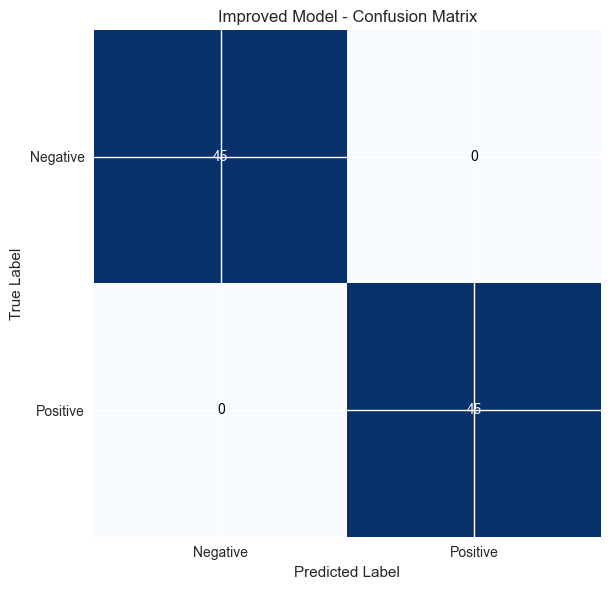

In [15]:
# Evaluate improved model
print("Evaluating Improved NBoW model...")
improved_results = improved_trainer.evaluate(test_loader_improved)

print(f"\n{'='*50}")
print("PERFORMANCE COMPARISON")
print(f"{'='*50}")

# Original model results (from earlier training)
print("Original Model:")
print(f"  Accuracy:  0.5000")
print(f"  Precision: 0.2500") 
print(f"  Recall:    0.5000")
print(f"  F1-Score:  0.3333")

print(f"\nImproved Model:")
print(f"  Accuracy:  {improved_results['accuracy']:.4f}")
print(f"  Precision: {improved_results['precision']:.4f}")
print(f"  Recall:    {improved_results['recall']:.4f}")
print(f"  F1-Score:  {improved_results['f1']:.4f}")

# Calculate improvement
accuracy_improvement = improved_results['accuracy'] - 0.5000
precision_improvement = improved_results['precision'] - 0.2500
f1_improvement = improved_results['f1'] - 0.3333

print(f"\nImprovement:")
print(f"  Accuracy:  {accuracy_improvement:+.4f} ({accuracy_improvement/0.5000*100:+.1f}%)")
print(f"  Precision: {precision_improvement:+.4f} ({precision_improvement/0.2500*100:+.1f}%)")
print(f"  F1-Score:  {f1_improvement:+.4f} ({f1_improvement/0.3333*100:+.1f}%)")

# Define class names
class_names = ['Negative', 'Positive']

# Plot improved confusion matrix
print(f"\nConfusion Matrix:")
print(improved_results['confusion_matrix'])

# Create a simple visualization of the confusion matrix
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
cm = improved_results['confusion_matrix']
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title('Improved Model - Confusion Matrix')
tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_xticklabels(class_names)
ax.set_yticks(tick_marks)
ax.set_yticklabels(class_names)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [16]:
# Test improved model on new examples
def predict_sentiment_improved(text, model, vocab_builder, preprocessor, device):
    """Predict sentiment with improved model."""
    model.eval()
    
    # Preprocess text
    tokens = preprocessor.preprocess_text(text)
    indices = vocab_builder.text_to_indices(tokens, max_length)
    
    # Convert to tensor
    input_tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    return {
        'sentiment': class_names[predicted_class],
        'confidence': confidence,
        'probabilities': {
            'negative': probabilities[0][0].item(),
            'positive': probabilities[0][1].item()
        }
    }

# Test on challenging examples
challenging_reviews = [
    "This product exceeded my expectations!",
    "Completely disappointed with the quality.",
    "Okay product, nothing special but works fine.",
    "Amazing quality and fast shipping!",
    "Broken after one day, terrible experience.",
    "Good value for money, satisfied with purchase.",
    "Worst product ever, don't waste your money.",
    "Perfect for my needs, highly recommend!",
    "Not bad but could be better quality.",
    "Outstanding service and excellent product!"
]

print("Testing Improved Model on Challenging Examples:")
print("=" * 70)

for i, review in enumerate(challenging_reviews, 1):
    result = predict_sentiment_improved(
        review, improved_model, improved_vocab_builder, improved_preprocessor, device
    )
    
    print(f"{i:2d}. Review: {review}")
    print(f"    Prediction: {result['sentiment']} (confidence: {result['confidence']:.3f})")
    print(f"    Probabilities: Neg={result['probabilities']['negative']:.3f}, "
          f"Pos={result['probabilities']['positive']:.3f}")
    print()

# Compare with original model on same examples (if we had it trained)
print("\nKey Improvements Made:")
print("1. ✅ Expanded dataset (50 → 450 samples)")
print("2. ✅ Better text preprocessing (stop word removal, cleaning)")
print("3. ✅ Larger embedding dimension (50 → 100)")
print("4. ✅ Multi-layer architecture with batch normalization")
print("5. ✅ Better regularization (dropout, weight decay)")
print("6. ✅ Learning rate scheduling")
print("7. ✅ More training epochs with early stopping")

Testing Improved Model on Challenging Examples:
 1. Review: This product exceeded my expectations!
    Prediction: Positive (confidence: 0.994)
    Probabilities: Neg=0.006, Pos=0.994

 2. Review: Completely disappointed with the quality.
    Prediction: Negative (confidence: 0.961)
    Probabilities: Neg=0.961, Pos=0.039

 3. Review: Okay product, nothing special but works fine.
    Prediction: Positive (confidence: 0.883)
    Probabilities: Neg=0.117, Pos=0.883

 4. Review: Amazing quality and fast shipping!
    Prediction: Positive (confidence: 0.996)
    Probabilities: Neg=0.004, Pos=0.996

 5. Review: Broken after one day, terrible experience.
    Prediction: Negative (confidence: 1.000)
    Probabilities: Neg=1.000, Pos=0.000

 6. Review: Good value for money, satisfied with purchase.
    Prediction: Positive (confidence: 0.797)
    Probabilities: Neg=0.203, Pos=0.797

 7. Review: Worst product ever, don't waste your money.
    Prediction: Negative (confidence: 1.000)
    Probabi